<div class="jumbotron text-left"><b>
    
This tutorial describes how to use the SMT toolbox to do some Bayesian Optimization (MOO method) to solve multi-objective unconstrained optimization problem
<div>
    
Robin Grapin - 2021
    
https://github.com/RobinGRAPIN?tab=repositories

# Problem definition

Let us go with a 2-objectives function from a 2-D variable. Feel free to choose the objectives within the SMT Problems and to change the bounds.

In [1]:
#import sys
#from collections import OrderedDict
#print(list(OrderedDict.fromkeys(sys.path)))
#sys.path.insert(0,'C:/Users/robin/bayesian-optim/smt')
#sys.path
#!pip install autograd
from platform import python_version
print(python_version()) #python version has to be > 3.6 to use pymoo

3.6.10


In [2]:
#imports
import numpy as np
from random import randint
import matplotlib.pyplot as plt

from smt.problems import Rosenbrock, Branin
from smt.sampling_methods import LHS
from smt.surrogate_models import LS, QP, KPLS, KRG, KPLSK, GEKPLS, MGP

from pymoo.algorithms.nsga2 import NSGA2
from pymoo.model.problem import Problem
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter

In [3]:
#problem definition
ndim = 2
ny = 2
fun1 = Rosenbrock(ndim=ndim)
fun2 = Branin(ndim=ndim)

#function to minimize
def objective(x):
    return [fun1(x), fun2(x)]
    
xlimits = np.array([[-2.0,2.0], [-2.0,2.0]])

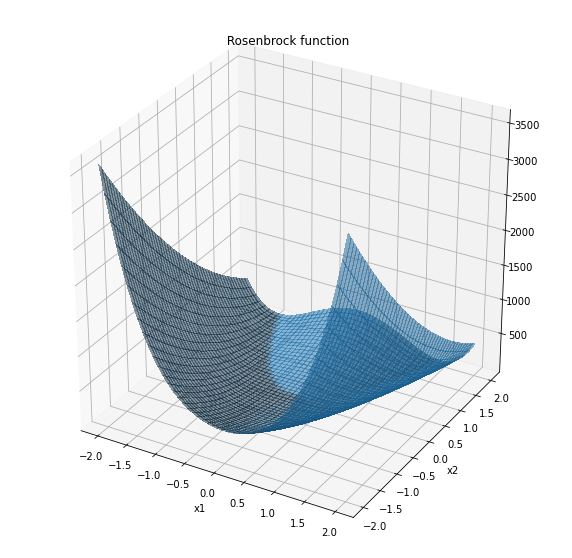

In [4]:
#plot of the first objective
%matplotlib inline
#To plot the Rosenbrock function
num_plot = 50 #to plot rosenbrock
x = np.linspace(xlimits[0][0],xlimits[0][1],num_plot)
res = []
for x0 in x:
    for x1 in x:
        res.append(fun1(np.array([[x0,x1]])))
res = np.array(res)
res = res.reshape((50,50)).T
X,Y = np.meshgrid(x,x)
fig = plt.figure(figsize=[10,10])
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, res,
                       linewidth=0, antialiased=False,alpha=0.5)
plt.title(' Rosenbrock function')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

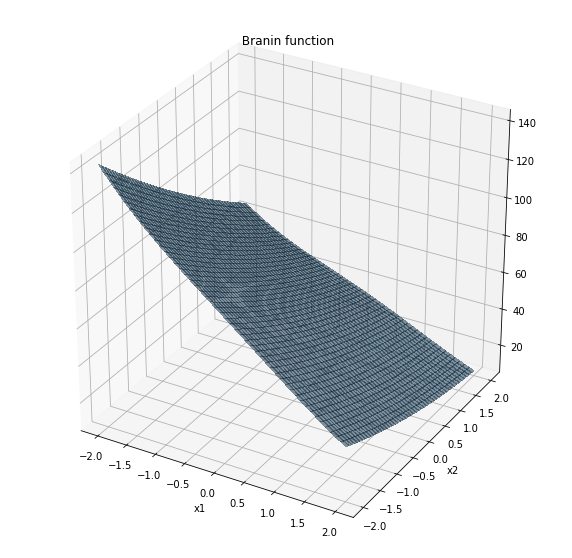

In [5]:
#Plot of the 2nd objective
%matplotlib inline
res2 = []
for x0 in x:
    for x1 in x:
        res2.append(fun2(np.array([[x0,x1]])))
res2 = np.array(res2)
res2 = res2.reshape((50,50)).T
fig = plt.figure(figsize=[10,10])
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, res2,
                       linewidth=0, antialiased=False,alpha=0.5)
plt.title(' Branin function')
plt.xlabel('x1')
plt.ylabel('x2')
plt.show()

# Real Pareto front

The goal in multi-objective optimization is to find a set of points dominated by no others. To see the Pareto front of our function, let's run the genetic algorithm NSGA2 on it, without using surrogates. This will serve for comparition later.


Compiled modules for significant speedup can not be used!
https://pymoo.org/installation.html#installation

To disable this warning:
from pymoo.configuration import Configuration
Configuration.show_compile_hint = False

n_gen |  n_eval |  n_nds  |     eps      |  indicator  
    1 |     100 |       7 |            - |            -
    2 |     200 |      10 |  0.048512864 |        ideal
    3 |     300 |      13 |  0.063567065 |        ideal
    4 |     400 |      16 |  0.013962172 |        ideal
    5 |     500 |      21 |  0.037321155 |            f
    6 |     600 |      27 |  0.032217709 |        ideal
    7 |     700 |      33 |  0.012048377 |            f
    8 |     800 |      38 |  0.003363461 |        ideal
    9 |     900 |      43 |  0.003377972 |        ideal
   10 |    1000 |      52 |  0.025269460 |        nadir
   11 |    1100 |      69 |  0.032579274 |        nadir
   12 |    1200 |      78 |  0.005820871 |        nadir
   13 |    1300 |      95 |  0.019093281 |        n

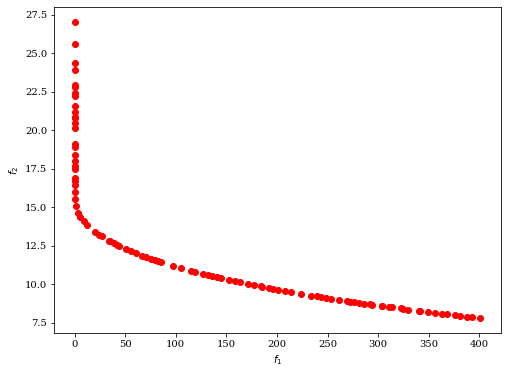

In [6]:
#creation of a Pymoo problem to be able to use NSGA2 on it
class MyProblem_reel(Problem):

    def __init__(self):
        super().__init__(n_var=2,
                         n_obj=2,
                         n_constr=0,
                         xl=np.array([-2.0, -2.0]),
                         xu=np.array([2.0, 2.0]),
                         elementwise_evaluation=True)

    def _evaluate(self, x, out, *args, **kwargs):
        xx = np.asarray(x).reshape(1, -1) #Our functions take array as entry
        f1 = fun1(xx)[0][0]
        f2 = fun2(xx)[0][0]
        out["F"] = [f1, f2]
        #out["G"] = [g1, g2] #no constraints at the moment

problem_exact = MyProblem_reel()

algorithm_bis = NSGA2(pop_size=100)

res_exact = minimize(problem_exact,
               algorithm_bis,
               ("n_gen", 100),
               verbose=True, #False if you do not want the text
               seed=1)

plot = Scatter()
plot.add(res_exact.F, color="red")
plot.show()

# Using a surrogate model

As the objective function might be expensive to call, using genetic algorithm on it can be very long. This is why MOO is used to :

 1) create a model withe the Krige method  
 2) refine the model chosing cleverly the points to evaluate  
 3) running NSGA2 on a good model to obtain the Pareto set and front  

In [7]:
from smt.applications.MOO import MOO

#creation of a MOO object
mo = MOO(n_iter = 10, #added points to refine the model
         n_start = 20, #points for the initial sampling (default sampling method : LHS)
         xlimits = xlimits, 
         n_gen=50, #number of generations for the genetic algorithm
         pop_size = 50)#number of new individuals at every generation of NSGA2

iteration  1
iteration  2
iteration  3
iteration  4
iteration  5
iteration  6
iteration  7
iteration  8
iteration  9
iteration  10
Model is well refined, NSGA2 is running...
Optimizatin done, get the front with .result.F and the et with .result.X


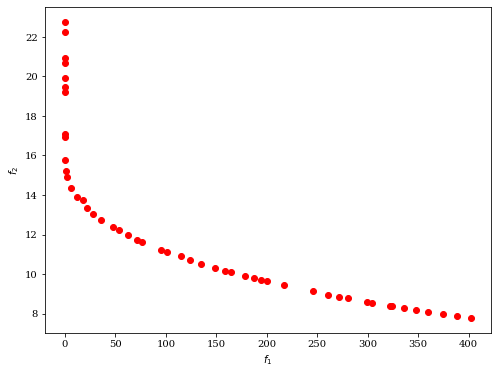

In [9]:
#optimization
mo.optimize(objective)

#vizualization of the Pareto front
res = mo.result
plot = Scatter()
plot.add(res.F, color="red")
plot.show()

<div>In this example, the objective function <code>objective</code> has been called *n_start + n_iter* times. </div>
We can see that the obtained front is close from the one obtained without using surrogates. You can now play with the function to optimize <code>objective</code>, the bounds <code>xlimits</code>, but also the parameters of MOO itself. For example, when defining the MOO object, you can declare <code>surrogate =</code> to choose a different modelization kernel or <code>criterion =</code> for a different activation function in the model's refining loop.